# 2D RNN test

imports:

In [1]:
%reset -f
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from NN import *
from MDRNN import *
tf.reset_default_graph()

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


some constants:

In [2]:
num_epochs = 20

state_size = 10
num_classes = 2

hidden_size = 6

board_width = 5
board_height = 5

total_n = 50000
batch_size = 50
num_batches = total_n // batch_size

Generate data, the board has random zeros and ones,
the labels are one if there are 2 ones at this position and to the left and to the right.

In [18]:
def generateBatch():
    x = np.random.choice(2, (batch_size, board_width, board_height, 1))
    y = np.zeros((batch_size, board_width, board_height))
    for idx in range(batch_size):
        for cx in range(board_width):
            for cy in range(board_height):
                n_neig = 0
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:#, (-1, 0)]: #, (-1, -1), (-1, 1), (1, -1)]:
                        #if dx == 0 and dy == 0:
                        #    continue
                        nx = cx+dx
                        ny = cy+dy
                        if 0 <= nx < board_width and 0 <= ny < board_height:
                            n_neig += x[idx][nx][ny][0]
                if n_neig > 4 and n_neig < 7:
                    y[idx][cx][cy] = 1
    return (x, y)

Create Weights:
(don't run these 2 to keep same weights active)

In [19]:
cells = [Dense(2 * state_size + 1, state_size)] * 4

run from here to keep weights:

In [43]:
X_placeholder = tf.placeholder(tf.float32, [batch_size, board_width, board_height, 1])
Y_placeholder = tf.placeholder(tf.int32, [batch_size, board_width, board_height])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])
state_grid = unroll2DRNN(cells, X_placeholder, init_state)

In [44]:
labels_grid = [tf.unstack(X, board_height, 1) for X in tf.unstack(Y_placeholder, board_width, 1)]

In [45]:
# final output network for each state:
logits_network = create_fully_connected(4 * state_size, [
    (tf.tanh, hidden_size),
    (None, num_classes)
])

concat_grid = concat2D(state_grid)
logits_grid = apply2D(logits_network, concat_grid)
estimate_grid = apply2D(tf.nn.softmax, logits_grid)

# losses and training:
losses = [[tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) 
               for logits, labels in zip(logits_series_y, labels_series_y)] 
          for logits_series_y, labels_series_y in zip(logits_grid, labels_grid)]

total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdamOptimizer().minimize(total_loss)

In [46]:
def format_out(out):
    return np.argmax(out, axis=3).transpose((2, 0, 1))

def accuracy(out, labels):
    return 100 * (1 - np.mean(np.abs(format_out(out) - labels)))

def plot(loss_list, valid_loss, valid_acc):
    plt.plot(np.linspace(0, len(loss_list), len(loss_list)), loss_list,
             np.linspace(0, len(loss_list), len(valid_loss)), valid_loss)
    plt.show()
    plt.plot(valid_acc)
    plt.show()

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Step 0 Loss 0.5515514


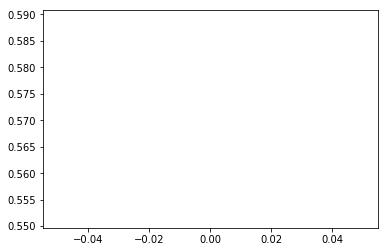

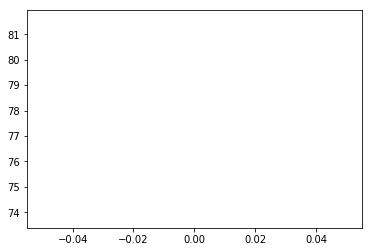

In [ ]:
#plt.ion()
#plt.figure()
#plt.show()
loss_list = []
valid_loss = []
valid_acc = []

valid_x, valid_y = generateBatch()

for batch_idx in range(num_batches * num_epochs):
    _current_state = np.zeros((batch_size, state_size))
    x, y = generateBatch()

    _total_loss, _train_step = sess.run(
        [total_loss, train_step],
        feed_dict={
            X_placeholder:x,
            Y_placeholder:y,
            init_state:_current_state
        })

    loss_list.append(_total_loss)
    if batch_idx % 100 == 0:
        _current_state = np.zeros((batch_size, state_size))
        _valid_loss, _out = sess.run(
            [total_loss, logits_grid],
            feed_dict = {
                X_placeholder: valid_x,
                Y_placeholder: valid_y,
                init_state:_current_state
            })
        valid_loss.append(_valid_loss)
        valid_acc.append(accuracy(_out, valid_y))
    if batch_idx % 1000 == 0:
        print("Step",batch_idx, "Loss", _total_loss)
        plot(loss_list, valid_loss, valid_acc)
        if valid_acc[-1] == 100:
            break
print("last loss:", loss_list[-1])

In [39]:
test_x, test_y = generateBatch()
test_x, test_y = test_x[0], test_y[0]
print("testing on: ")
print(test_x)
print("correct out: ")
print(test_y)
test_state = tf.placeholder(tf.float32, [1, state_size]) # one batch

X_test = tf.placeholder(tf.float32, [1, board_width, board_height, 1])

testing on: 
[[[0]
  [1]
  [0]
  [1]
  [1]]

 [[0]
  [1]
  [1]
  [1]
  [1]]

 [[0]
  [0]
  [1]
  [0]
  [1]]

 [[0]
  [0]
  [0]
  [1]
  [0]]

 [[0]
  [0]
  [0]
  [1]
  [1]]

 [[1]
  [0]
  [1]
  [1]
  [0]]]
correct out: 
[[0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


In [40]:
test_grid = unroll2DRNN(cells, X_test, test_state)

test_logits_grid = apply2D(logits_network, concat2D(test_grid))

In [41]:
cur_state = np.zeros((1, state_size))
out = sess.run(test_logits_grid, 
               feed_dict = {
                    test_state: cur_state,
                    X_test: test_x.reshape((1, board_width, board_height, 1))
               })

In [42]:
print("output: ")
print(format_out(out))
print("acc: ", accuracy(out, test_y))

output: 
[[[0 0 0 0 0]
  [0 0 1 1 0]
  [0 0 0 1 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
acc:  76.66666666666666


In [38]:
board_width = 6
board_height = 5

Nu kunt ge de vorige 4 cellen opnieuw uitvoeren

In [47]:
sess.run( tf.initialize_variables( list( tf.get_variable(name) for name in sess.run( tf.report_uninitialized_variables( tf.global_variables( ) ) ) ) ) )

ValueError: Shape of a new variable (b'beta1_power_2') must be fully defined, but instead was <unknown>.

In [20]:
accuracy(out, test_y)

100.0

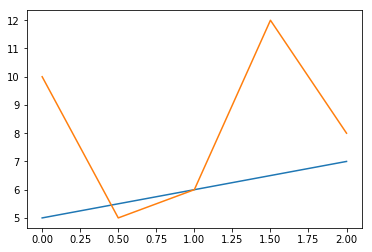

In [21]:
plt.plot([0, 1, 2], [5, 6, 7], [0, 0.5, 1, 1.5, 2], [10, 5, 6, 12, 8])